To launch in SuperCloud from a Computed Node


LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-cpu --cpus-per-task=40 srun    --pty bash -i

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

Latest server: http://d-5-1-1:8890/lab?token=d4c4cd5e31f355ef9689a4d8d1b1162dfd00d681ae04a407

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import gymnasium as gym
from gymnasium import spaces
import subprocess
import multiprocessing
import concurrent.futures
import os
import random
from collections import defaultdict
import socket

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv


In [2]:
def small_topology_plot(graph_networkx):
    pos = nx.spring_layout(graph_networkx)
    color = 'lightblue'
    plt.figure(figsize=(3, 3))
    nx.draw(graph_networkx, pos, with_labels=False, node_color=color, node_size=250, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(graph_networkx, pos, font_size=8, font_color='black')
    plt.show()   

def topology_plot_with_attrs(G, node_attr = None, edge_attr = None, seed=42):

    if node_attr is None:
        first_node_attrs = next(iter(G.nodes(data=True)), (None, {}))[1]
        node_attr = next(iter(first_node_attrs), None)

    if edge_attr is None:
        for _, _, d in G.edges(data=True):
            if d:
                edge_attr = next(iter(d))
                break


    pos = nx.spring_layout(G, seed=seed)
    plt.figure(figsize=(5, 5)); plt.axis("off")


    node_labels = {}
    default_colour = "lightblue"          
    node_colors   = default_colour

    if node_attr is not None:
        values = [G.nodes[n].get(node_attr) for n in G.nodes()]


        if all(isinstance(v, (int, float)) for v in values if v is not None):
            norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
            cmap = cm.get_cmap("viridis")
            node_colors = [cmap(norm(v)) for v in values]


        else:
            present_vals = {v for v in values if v is not None}

            unique_vals  = sorted(present_vals, key=lambda x: str(x))

            palette     = cycle(cm.tab20.colors)
            colour_map  = {val: next(palette) for val in unique_vals}
            missing_col = "#d3d3d3"                     # grey for None
            node_colors = [colour_map.get(v, missing_col) for v in values]


        for n in G.nodes():
            val = G.nodes[n].get(node_attr)
            node_labels[n] = f"{n}\n{node_attr}={val}"

    else:
        node_labels = {n: n for n in G.nodes()}


    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
    nx.draw_networkx_edges(G, pos, arrows=G.is_directed())
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)


    if edge_attr is not None:
        edge_labels = {
            (u, v): f"{edge_attr}={d.get(edge_attr)}"
            for u, v, d in G.edges(data=True) if edge_attr in d
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)


    if node_attr and not all(isinstance(v, (int, float)) for v in values if v is not None):
        handles = [
            plt.Line2D([0], [0], marker="o", color="w",
                       markerfacecolor=colour_map[val], markersize=8,
                       label=str(val))
            for val in unique_vals
        ]
        if any(v is None for v in values):
            handles.append(
                plt.Line2D([0], [0], marker="o", color="w",
                           markerfacecolor=missing_col, markersize=8,
                           label="None")
            )
        plt.legend(title=node_attr, handles=handles,
                   bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout(); plt.show()

def permute_graph(graph, permutation):
    mapping = {old: new for old, new in zip(input_nodes, permutation)}
    permuted_graph = nx.relabel_nodes(graph, mapping)
    return permuted_graph

In [3]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs: {multiprocessing.cpu_count()}")


Node: d-5-1-1
GPUs: 0
CPUs: 96


#### Parameters

In [4]:
circuit_name = "0x17"

#File with designs 
#file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250628_single_circuit_0x0A/seed_1/optimal_topologies/optimal_topologies.pkl"

file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/0x00BF_ML_topology_designs_reduced.pkl"

# Set up output directory
#output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/runs/0x2B/test/"


#Path(output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 1


In [6]:
type(reduced_graphs)

list

In [7]:
#Select graph in graphs
selected_graph = 0     


In [8]:
# Variables for preparing data for training 
np.random.seed(42)


In [9]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [0, 1, 2]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (0, 1, 2)
Permuted graphs 1: (0, 2, 1)


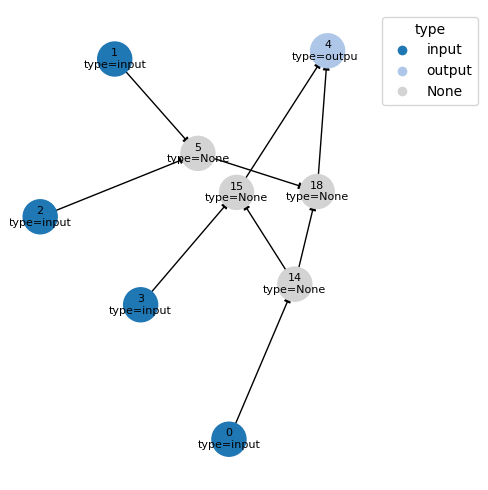

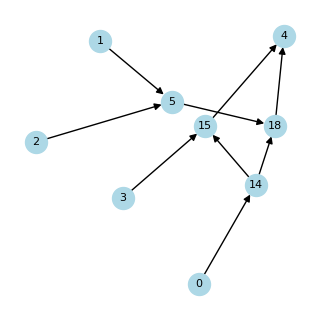

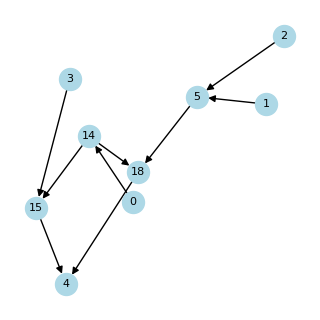

In [10]:

topology_plot_with_attrs(topology_networkx)

for topology_permutation in permuted_graphs:
    small_topology_plot(topology_permutation) 

Convert to matrix and node features

In [11]:
current_solution = permuted_graphs[0]
max_nodes = 11

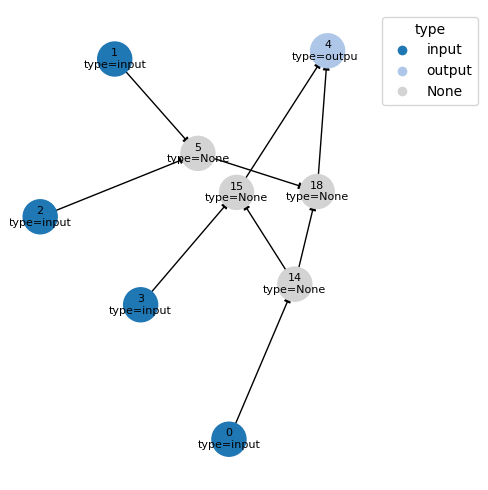

In [12]:
topology_plot_with_attrs(current_solution)

In [13]:
#test the one-hot encodding and obs in the env
#nodes = list(nx.topological_sort(current_solution))
nodes = list(sorted(current_solution))
adj_dense = nx.adjacency_matrix(current_solution, nodelist=nodes).toarray()
adj = np.asarray(resize_matrix(adj_dense, max_nodes), dtype=np.float32)
feats = np.asarray(
    generate_one_hot_features_from_adj(
        nx.adjacency_matrix(current_solution, nodelist=nodes),
        pad_size=max_nodes,
    ),
    dtype=np.float32,
        )

In [14]:
nodes

[0, 1, 2, 3, 4, 5, 14, 15, 18]

In [15]:
adj

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [16]:
print(nx.adjacency_matrix(current_solution, nodelist=nodes))

  (0, 6)	1
  (1, 5)	1
  (2, 5)	1
  (3, 7)	1
  (5, 8)	1
  (6, 7)	1
  (6, 8)	1
  (7, 4)	1
  (8, 4)	1


In [17]:
feats

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

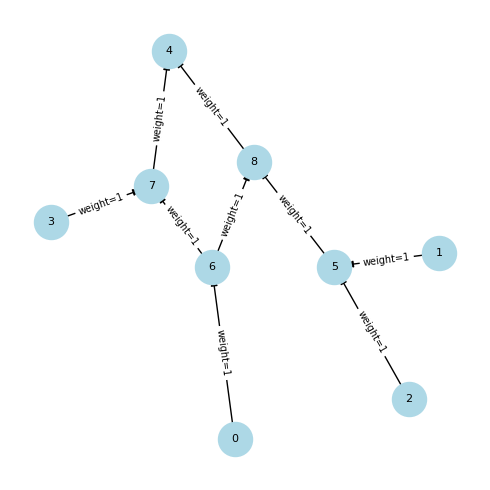

In [18]:
#reconstruct the graph from the adjacency_matrix
A = nx.adjacency_matrix(current_solution, nodelist=nodes)

# 1.  Re-create the graph structure (keeps edge directions)
G_tmp = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)

topology_plot_with_attrs(G_tmp, seed = 96982)

This is inside the generate_one_hot_features_from_adj function

In [19]:
pad_size = max_nodes
print(f"nodes are {nodes}")
adj_matrix_sparse = nx.adjacency_matrix(current_solution, nodelist=nodes)
adj_matrix = adj_matrix_sparse.toarray()

# Number of nodes
num_nodes = adj_matrix.shape[0]

# Initialize a feature matrix with zeros
num_classes = 4  # Four classes as described
features = np.zeros((num_nodes, num_classes), dtype=np.float32)

# Calculate in-degree (sum of each column) and out-degree (sum of each row)
in_degree = np.sum(adj_matrix, axis=0)  # In-degree is the column sum
out_degree = np.sum(adj_matrix, axis=1)  # Out-degree is the row sum

for idx in range(num_nodes):
    # Assign class based on the input/output criteria
    if out_degree[idx] == 0:
        features[idx, 3] = 1  # Class 4: No outputs
    elif in_degree[idx] == 0:
        features[idx, 2] = 1  # Class 3: No inputs (circuit output)
    elif in_degree[idx] == 1 and out_degree[idx] > 0:
        features[idx, 0] = 1  # Class 1: One input and at least one output (NOT)
    elif in_degree[idx] == 2 and out_degree[idx] > 0:
        features[idx, 1] = 1  # Class 2: Two inputs and at least one output (NOR)

# Padding logic
if pad_size is not None and pad_size > num_nodes:
    # Pad the matrix with zeros to the desired pad_size
    padded_features = np.zeros((pad_size, num_classes), dtype=np.float32)
    padded_features[:num_nodes, :] = features
    print(padded_features)
else:
    # Return original matrix if no padding is needed or pad_size <= num_nodes
    print(features)

nodes are [0, 1, 2, 3, 4, 5, 14, 15, 18]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [20]:
#sparse format 
print(adj_matrix_sparse)

  (0, 6)	1
  (1, 5)	1
  (2, 5)	1
  (3, 7)	1
  (5, 8)	1
  (6, 7)	1
  (6, 8)	1
  (7, 4)	1
  (8, 4)	1


In [21]:
#dense format
print(adj_matrix_sparse.toarray())

[[0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


In [22]:
#vector showing the number of incoming edges for nodes
in_degree

array([0, 0, 0, 0, 2, 2, 1, 2, 2])

In [23]:
#ector showing the number of outgoing edges for nodes
out_degree

array([1, 1, 1, 1, 0, 1, 2, 1, 1])

Now in the neural network

In [24]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, A2C

import torch as th
import torch.nn as nn
import torch_geometric.nn as geom_nn

import torch.nn.functional as F

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib import MaskablePPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

from sb3_contrib.common.wrappers import ActionMasker

from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback
from stable_baselines3.common.logger import configure

class GAT(BaseFeaturesExtractor):
    """
    Pre-norm GATv2 stack with residual projections, optional node-feature
    embedding and attention pooling.
    """

    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 128, *, embed_dim: 'int | None' = None):
        super().__init__(observation_space, features_dim)

        in_node_dim = observation_space["node_features"].shape[1]  # =4 (one-hot)
        self.node_embed: 'nn.Module | None' = None
        if embed_dim is not None:
            # one-hot (N,4) · W(4,embed_dim)  →  (N,embed_dim)
            self.node_embed = nn.Linear(in_node_dim, embed_dim, bias=False)
            in_node_dim = embed_dim                      # GNN now sees embed_dim

        layer_cfg = [(32, 4), (64, 4), (64, 4)]          # (out_dim, heads)
        self.gnn_layers = nn.ModuleList()
        cur_dim = in_node_dim

        for out_dim, heads in layer_cfg:
            out_channels = out_dim * heads               # concat=True
            conv = geom_nn.GATv2Conv(
                in_channels=cur_dim,
                out_channels=out_dim,
                heads=heads,
                concat=True,
                dropout=0.1,
            )
            norm = nn.LayerNorm(cur_dim)                 # pre-norm
            proj = (
                None
                if cur_dim == out_channels
                else nn.Linear(cur_dim, out_channels, bias=False)
            )          

            self.gnn_layers.append(nn.ModuleDict({"conv": conv, "norm": norm, "proj": proj}))
            cur_dim = out_channels


        self.global_pool = geom_nn.AttentionalAggregation(
            gate_nn=nn.Sequential(
                nn.Linear(cur_dim, cur_dim // 2),
                nn.ReLU(),
                nn.Linear(cur_dim // 2, 1),
            )
        )
        self.gcn_out_dim = cur_dim


        hidden_dim = 256                 
        self.combined_net = nn.Sequential(
            nn.Linear(self.gcn_out_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),  
            nn.ReLU(),
            nn.Linear(hidden_dim, features_dim) 
        )

    def adj_matrix_to_edge_index(self, adj_matrix: th.Tensor) -> th.Tensor:
        row, col = (adj_matrix > 0).nonzero(as_tuple=True)
        edge_index = th.stack([row, col], dim=0).to(adj_matrix.device)
        return edge_index

    def encode_graph(self, x: th.Tensor, adj: th.Tensor) -> th.Tensor:
        if self.node_embed is not None:                  # optional embedding
            x = self.node_embed(x)

        edge_index = self.adj_matrix_to_edge_index(adj)

        for layer in self.gnn_layers:
            h = layer["conv"](layer["norm"](x), edge_index)   # pre-norm
            res = x if layer["proj"] is None else layer["proj"](x)
            x = F.relu(res + h)                               # residual + act

        batch = th.zeros(x.size(0), dtype=th.long, device=x.device)
        return self.global_pool(x, batch)

    def process_graph(self, node_features: th.Tensor, adj_matrix: th.Tensor) -> th.Tensor:
        if adj_matrix.dim() == 3:  # batched
            outs = [
                self.encode_graph(node_features[i], adj_matrix[i])
                for i in range(adj_matrix.size(0))
            ]
            return th.stack(outs)
        return self.encode_graph(node_features, adj_matrix)

    def forward(self, observation):
        device = next(self.parameters()).device

        node_features = th.as_tensor(observation["node_features"], dtype=th.float32, device=device)
        adj_matrix    = th.as_tensor(observation["adj_matrix"],    dtype=th.float32, device=device)

        graph_emb = self.process_graph(node_features, adj_matrix)
        if graph_emb.dim() == 3:                        # (B,1,D) -> (B,D)
            graph_emb = graph_emb.view(graph_emb.size(0), -1)

        return self.combined_net(graph_emb)

# Update policy_kwargs with the new class
policy_kwargs = dict(
    features_extractor_class=GAT,
    features_extractor_kwargs=dict(features_dim=128),
    net_arch=dict(pi=[100, 100, 100, 100, 100], vf=[100, 100, 100, 100, 100])
) 

In [25]:

observation_space = gym.spaces.Dict({
    "node_features": gym.spaces.Box(low=0, high=1, shape=(max_nodes, 4), dtype=float),
    "adj_matrix":    gym.spaces.Box(low=0, high=1, shape=(max_nodes, max_nodes), dtype=float),
})

feature_dim = 128                       # what your policy expects
extractor   = GAT(observation_space, features_dim=feature_dim, embed_dim=None)

In [26]:
node_features = th.as_tensor(feats, dtype=th.float32)
adj_matrix    = th.as_tensor(adj,    dtype=th.float32)

extractor.adj_matrix_to_edge_index(adj_matrix)

tensor([[0, 1, 2, 3, 5, 6, 6, 7, 8],
        [6, 5, 5, 7, 8, 7, 8, 4, 4]])

In [27]:
adj

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [28]:
node_features


tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [29]:
adj_matrix 

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

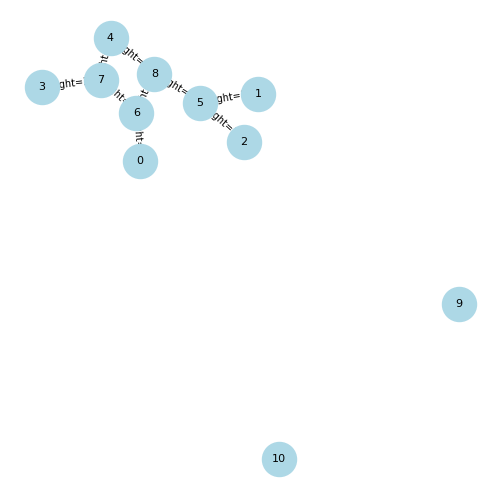

In [30]:
#reconstruct graph from the neural network view

G = nx.from_numpy_array(adj_matrix.detach().cpu().numpy().astype(np.float32), create_using=nx.DiGraph)

topology_plot_with_attrs(G, seed = 96982)



In [31]:
from torch_geometric.data import Data

#edge_index = th.tensor([[0, 1, 1, 2],
#                           [1, 0, 2, 1]], dtype=th.long)

edge_index = extractor.adj_matrix_to_edge_index(adj_matrix)
#x = th.tensor([[-1], [0], [1]], dtype=th.float)
x = node_features
data = Data(x=x, edge_index=edge_index)
data

Data(x=[11, 4], edge_index=[2, 9])

In [32]:
data.num_nodes

11

In [33]:
data.num_edges

9

In [34]:
data.num_node_features

4

In [35]:
data.has_isolated_nodes()

True

Studying the effect of permutaiton of inputs on graph encoding and processing

In [36]:
max_nodes = 10
current_solution = permuted_graphs[0]
nodes = list(nx.topological_sort(current_solution))
#nodes = list(sorted(current_solution))
adj_dense = nx.adjacency_matrix(current_solution, nodelist=nodes).toarray()
adj = np.asarray(resize_matrix(adj_dense, max_nodes), dtype=np.float32)
feats = np.asarray(
    generate_one_hot_features_from_adj(
        nx.adjacency_matrix(current_solution, nodelist=nodes),
        pad_size=max_nodes,
    ),
    dtype=np.float32,
        )

node_features = th.as_tensor(feats, dtype=th.float32)
adj_matrix    = th.as_tensor(adj,    dtype=th.float32)


th.manual_seed(42)             
np.random.seed(42)

extractor.eval()

with th.no_grad():
    graph_emb = extractor.process_graph(node_features, adj_matrix)
    nn_output = extractor.combined_net(graph_emb)

print(nn_output)


tensor([[-0.1523, -0.0949, -0.0497,  0.0624,  0.1287, -0.0951,  0.1790, -0.0828,
         -0.0876, -0.0644,  0.1283, -0.1180, -0.0041,  0.0057, -0.1262, -0.0263,
          0.0272,  0.0462, -0.1182,  0.0334, -0.0165, -0.1634, -0.0785,  0.1316,
          0.0901, -0.1054, -0.0430,  0.0351, -0.0181,  0.1079,  0.0427,  0.1260,
          0.0112,  0.0485, -0.0205, -0.0092,  0.0337,  0.1954,  0.0265,  0.2723,
         -0.0329, -0.0927, -0.1371,  0.0027,  0.0564, -0.1387,  0.1272,  0.0261,
          0.0925, -0.0212, -0.0508,  0.0257, -0.1003,  0.0920, -0.0290, -0.0557,
          0.0679, -0.0445, -0.0573, -0.1269, -0.0197,  0.0704, -0.1060,  0.1141,
         -0.0212,  0.0045, -0.0095, -0.1523,  0.0583, -0.1174,  0.0101, -0.0031,
         -0.2018, -0.0480, -0.0652,  0.0022,  0.0431,  0.0912,  0.0259,  0.0552,
          0.0909,  0.0650, -0.0136, -0.0793,  0.0304,  0.0574, -0.0459, -0.0851,
          0.0214, -0.0048,  0.0295,  0.0993, -0.1133,  0.1289, -0.0998, -0.0616,
          0.0873,  0.1282, -

In [37]:
import torch as th
import numpy as np
from tqdm import tqdm

# ------------------------------------------------------------------
# deterministic set-up (CPU only)
# ------------------------------------------------------------------
th.manual_seed(42)
np.random.seed(42)
extractor.eval()                     # turn off all dropout layers

# ------------------------------------------------------------------
max_nodes = 100                    # pad / truncate size
outputs   = []                       # store every permutation's result
differs   = []                       # indices whose output ≠ reference

# ------------------------------------------------------------------
for idx, G in tqdm(list(enumerate(permuted_graphs)), desc="permutations"):

    # --- build padded adjacency and node-feature tensors ------------
    #nodes      = sorted(G)                                      # fixed order
    nodes = list(nx.topological_sort(G))
    adj_dense  = nx.adjacency_matrix(G, nodelist=nodes).toarray()
    adj_padded = np.asarray(resize_matrix(adj_dense, max_nodes),
                            dtype=np.float32)

    feats      = np.asarray(
        generate_one_hot_features_from_adj(
            nx.adjacency_matrix(G, nodelist=nodes),
            pad_size=max_nodes),
        dtype=np.float32)

    node_features = th.as_tensor(feats,      dtype=th.float32)
    adj_matrix    = th.as_tensor(adj_padded, dtype=th.float32)

    # --- forward pass ----------------------------------------------
    with th.no_grad():
        graph_emb = extractor.process_graph(node_features, adj_matrix)
        nn_out     = extractor.combined_net(graph_emb)

    outputs.append(nn_out.detach().cpu().numpy())

    # --- compare to the first output -------------------------------
    if idx == 0:
        ref_bytes = outputs[0].tobytes()      # reference
    elif outputs[-1].tobytes() != ref_bytes:  # byte-level check
        differs.append(idx)

# ------------------------------------------------------------------
# summary
# ------------------------------------------------------------------
if differs:
    print(f"\n{len(differs)} / {len(permuted_graphs)} permutations "
          f"produce a different nn_output → indices: {differs}")
else:
    print(f"\nAll {len(permuted_graphs)} permutations give identical nn_output ✔")


permutations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.61it/s]


All 2 permutations give identical nn_output ✔


Studying the effect of padding 

In [38]:
import torch as th
import numpy as np
import networkx as nx          # make sure nx is imported
from tqdm import tqdm

# ------------------------------------------------------------------
# deterministic setup (CPU only)
# ------------------------------------------------------------------
th.manual_seed(42)
np.random.seed(42)
extractor.eval()                         # turn off Dropout etc.

# ------------------------------------------------------------------
# choose a single graph (the first permutation)
# ------------------------------------------------------------------
G            = permuted_graphs[0]
nodes        = list(nx.topological_sort(G))      # fixed node order
n_real_nodes = len(nodes)                        # ground-truth size

# define the padding sizes you want to test
pad_sweep = list(range(n_real_nodes, 101, 5))    # e.g. N, N+5, …, 100

baseline_out = None
print("\nPadding-sweep results (difference vs. baseline):")
print("-------------------------------------------------")

for max_nodes in pad_sweep:
    # ---- build padded adjacency & features ------------------------
    adj_dense  = nx.adjacency_matrix(G, nodelist=nodes).toarray()
    adj_padded = np.asarray(resize_matrix(adj_dense, max_nodes),
                            dtype=np.float32)

    feats      = np.asarray(
        generate_one_hot_features_from_adj(
            nx.adjacency_matrix(G, nodelist=nodes),
            pad_size=max_nodes),
        dtype=np.float32)

    node_features = th.as_tensor(feats,      dtype=th.float32)
    adj_matrix    = th.as_tensor(adj_padded, dtype=th.float32)

    # ---- forward pass --------------------------------------------
    with th.no_grad():
        graph_emb = extractor.process_graph(node_features, adj_matrix)
        nn_out    = extractor.combined_net(graph_emb).cpu().numpy()

    # ---- compare with reference ----------------------------------
    if baseline_out is None:
        baseline_out = nn_out
        print(f"max_nodes = {max_nodes:>3}: baseline stored")
    else:
        # here we use max absolute difference; switch to np.linalg.norm for L2 if preferred
        diff = np.max(np.abs(nn_out - baseline_out))
        print(f"max_nodes = {max_nodes:>3}: max|Δ| = {diff:.6g}")



Padding-sweep results (difference vs. baseline):
-------------------------------------------------
max_nodes =   9: baseline stored
max_nodes =  14: max|Δ| = 0.0455759
max_nodes =  19: max|Δ| = 0.067172
max_nodes =  24: max|Δ| = 0.0819897
max_nodes =  29: max|Δ| = 0.0915992
max_nodes =  34: max|Δ| = 0.0972432
max_nodes =  39: max|Δ| = 0.100844
max_nodes =  44: max|Δ| = 0.103117
max_nodes =  49: max|Δ| = 0.105988
max_nodes =  54: max|Δ| = 0.108617
max_nodes =  59: max|Δ| = 0.110895
max_nodes =  64: max|Δ| = 0.112827
max_nodes =  69: max|Δ| = 0.11448
max_nodes =  74: max|Δ| = 0.115911
max_nodes =  79: max|Δ| = 0.117159
max_nodes =  84: max|Δ| = 0.118255
max_nodes =  89: max|Δ| = 0.119216
max_nodes =  94: max|Δ| = 0.12007
max_nodes =  99: max|Δ| = 0.120825


Studying how actions get affected by input permutation

In [39]:
from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

Done loading action motifs. There are 15928 unique motifs.


In [40]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]         
TTABLE_TO_ACTIONS = action_motifs["lookup"]
NUM_ACTIONS = len(UNIQUE_GRAPHS)

print(f"Imported DRL3env with {NUM_ACTIONS} rewrite motifs available.")

def truth_table_signature(tt):
    """
    Convert the dict {inputs → outputs} returned by calculate_truth_table_v2
    into a single immutable tuple that can be used as a dict key.
    For multi-output circuits we simply concatenate the bits.
    """
    flat = []
    for inp in sorted(tt):                 # lexicographic input order
        # 'outputs' is a tuple even for single-output circuits
        flat.extend(tt[inp])
    return tuple(flat)  

def hex_from_signature(sig):
    """
    Convert a truth-table signature tuple, e.g. (0,1,1,0,0,1,1,0),
    into its hexadecimal representation.

    • The first element of `sig` is treated as the most-significant bit,
      matching the convention in your NIG file names.
    • Pads with leading zeroes so that 4 signature bits → 1 hex digit.
    """
    val = 0
    for bit in sig:
        val = (val << 1) | bit
    width = max(1, len(sig) // 4)              # 8 bits → 2 hex digits, etc.
    return f"0x{val:0{width}X}"                # uppercase hex

Imported DRL3env with 15928 rewrite motifs available.


In [ ]:
current_solution = reduced_graphs[0] 

# Define the input nodes
input_nodes = [0, 1, 2]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_current_solution = []

for perm in permutations:
    new_graph = permute_graph(current_solution, perm)
    
    hex_str = hex_from_signature(truth_table_signature(calculate_truth_table_v2(new_graph)))

    idx = len(permuted_graphs)          
    print(f"Permuted current solution {idx}: {perm} →  {hex_str}")      
    permuted_current_solution.append(new_graph)  


for idx, sg in tqdm(list(enumerate(permuted_current_solution)), desc="permutations"):
    key = _compute_truth_key(sg)
    print(TTABLE_TO_ACTIONS.get(key, []))

Permuted current solution 2: (0, 1, 2) →  0x00BF
Permuted current solution 2: (0, 2, 1) →  0x00BF
Permuted current solution 2: (1, 0, 2) →  0x0B0F
Permuted current solution 2: (1, 2, 0) →  0x0B0F
Permuted current solution 2: (2, 0, 1) →  0x2333
Permuted current solution 2: (2, 1, 0) →  0x2333


permutations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2061.76it/s]

[563, 843, 904, 1097, 2841, 2846]
[563, 843, 904, 1097, 2841, 2846]
[563, 843, 904, 1097, 2841, 2846]
[563, 843, 904, 1097, 2841, 2846]
[563, 843, 904, 1097, 2841, 2846]
[563, 843, 904, 1097, 2841, 2846]
